# Winter Project

In [2]:
import os
import kagglehub
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/home/aparr/anaconda3/envs/cais_tensor_2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-21 00:33:11.027880: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 00:33:11.091686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734769991.138260   70973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734769991.151717   70973 cuda_bla

In [3]:
seed = 42

In [4]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /home/aparr/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [13]:
BATCH_SIZE = 32
from keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Files
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip = True,
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)


train_dataset = train_datagen.flow_from_directory(
    os.path.join(path, 'train'),
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

test_dataset = validation_datagen.flow_from_directory(
    os.path.join(path, 'test'),
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

# train_dataset = image_dataset_from_directory(
#     os.path.join(path, 'train'),
#     label_mode = 'categorical',
#     color_mode = 'grayscale',
#     batch_size = BATCH_SIZE,
#     image_size = (48, 48),
#     shuffle = True,
#     seed = seed
# )

# train_iter = iter(train_dataset)

# test_dataset = image_dataset_from_directory(
#     os.path.join(path, 'test'),
#     label_mode = 'categorical',
#     color_mode = 'grayscale',
#     batch_size = BATCH_SIZE,
#     image_size = (48, 48),
#     shuffle = False,
# )
# test_iter = iter(test_dataset)
# test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
# test_labels = pd.from_dummies(pd.DataFrame(test_labels))[''].to_numpy() # Convert from one hot

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


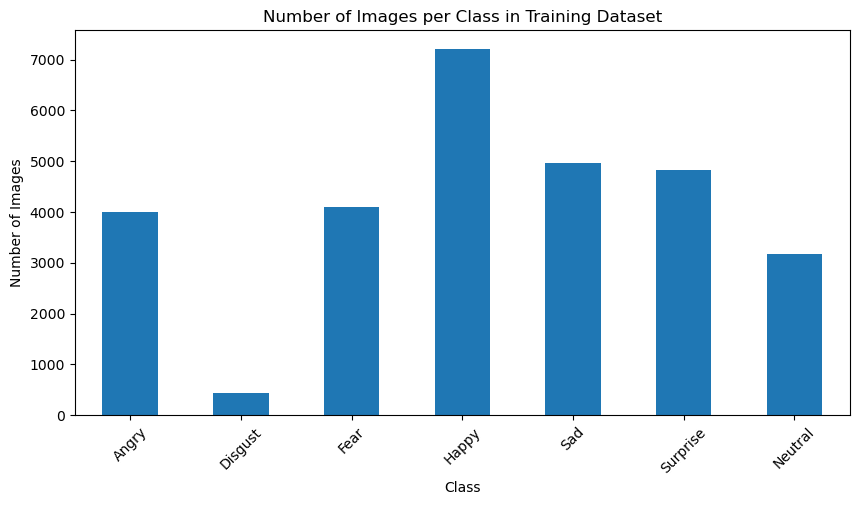

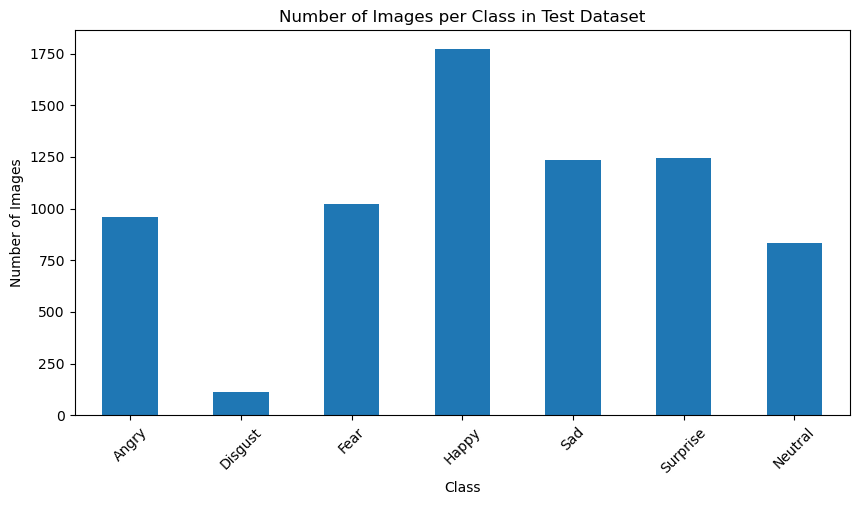

Number of images per class in the training dataset:
Label
0    3995
1     436
2    4097
3    7215
4    4965
5    4830
6    3171
Name: count, dtype: int64
Number of images per class in the test dataset:
Label
0     958
1     111
2    1024
3    1774
4    1233
5    1247
6     831
Name: count, dtype: int64


In [109]:
# Define class names
class_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

train_labels = np.array(train_dataset.labels)
test_labels = np.array(test_dataset.labels)

# Create dataframes for train and test labels
train_labels_df = pd.DataFrame(train_labels, columns=['Label'])
test_labels_df = pd.DataFrame(test_labels, columns=['Label'])

# Plot the number of images per class for the training dataset
plt.figure(figsize=(10, 5))
train_labels_df['Label'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Images per Class in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(ticks=np.arange(len(class_names)), labels=[class_names[i] for i in range(len(class_names))], rotation=45)
plt.show()

# Plot the number of images per class for the test dataset
plt.figure(figsize=(10, 5))
test_labels_df['Label'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Images per Class in Test Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(ticks=np.arange(len(class_names)), labels=[class_names[i] for i in range(len(class_names))], rotation=45)
plt.show()

print(train_labels_df['Label'].value_counts().sort_index())

print(test_labels_df['Label'].value_counts().sort_index())

In [105]:
FILTERS = 32
FILTER_SZ = 3
STRIDE = (1,1)
POOL_SZ = 2
from keras import models, layers, optimizers, callbacks

model = models.Sequential([
    layers.InputLayer(input_shape=(48,48,1), name='input'),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(FILTERS, FILTER_SZ, strides=STRIDE, activation='relu'),
    layers.MaxPooling2D(POOL_SZ),
    layers.BatchNormalization(),
    layers.Conv2D(FILTERS*2, FILTER_SZ, strides=STRIDE, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(FILTERS*2, FILTER_SZ, strides=STRIDE, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(FILTERS*2, FILTER_SZ, strides=STRIDE, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(POOL_SZ),
    layers.Conv2D(FILTERS*3, FILTER_SZ, strides=STRIDE, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Flatten(),
    layers.Dense(7, activation='softmax')
])

model.summary()

optimizer = optimizers.Adam(learning_rate=0.02)

model.compile(
    optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'categorical_crossentropy'],
)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_214 (Conv2D)             │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_215 (Conv2D)             │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_204         │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_216 (Conv2D)             │ (None, 42, 42, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_205         │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_217 (Conv2D)             │ (None, 40, 40, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_206         │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_218 (Conv2D)             │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_207         │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_219 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_208         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_220 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_209         │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_221 (Conv2D)             │ (None, 5, 5, 96)       │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_210         │ (None, 5, 5, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 5, 5, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 7)              │        16,80

 Total params: 194,279 (758.90 KB)

 Trainable params: 193,447 (755.65 KB)

 Non-trainable params: 832 (3.25 KB)

In [106]:
EPOCHS = 20
model_name = 'model6'
checkpoint = callbacks.ModelCheckpoint('saved/'+model_name+'.keras', monitor='categorical_crossentropy', verbose=1, 
                             save_best_only=True, mode='max', save_freq='epoch')

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="categorical_crossentropy",
    factor=0.3,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.08,
    cooldown=0,
    min_lr=0.0,
)

history = model.fit( 
    train_dataset,
    epochs = EPOCHS,
    validation_data = (test_dataset),
    callbacks=[reduce_lr, checkpoint]
)
model.save('models/'+model_name+'_end.keras')
history_df=pd.DataFrame(history.history)
history_df.to_csv('models/'+model_name+'.csv')

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2272 - categorical_crossentropy: 3.0956 - loss: 3.0956
Epoch 1: categorical_crossentropy improved from -inf to 2.19980, saving model to saved/model6.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.2272 - categorical_crossentropy: 3.0946 - loss: 3.0946 - val_accuracy: 0.2014 - val_categorical_crossentropy: 492.9324 - val_loss: 492.9324 - learning_rate: 0.0200
Epoch 2/20
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2543 - categorical_crossentropy: 1.8373 - loss: 1.8373
Epoch 2: categorical_crossentropy did not improve from 2.19980
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.2543 - categorical_crossentropy: 1.8373 - loss: 1.8373 - val_accuracy: 0.2782 - val_categorical_crossentropy: 1.7930 - val_loss: 1.7930 - learning_rate: 0.0200
Epoch 3/20
894/898 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2705 - categorical_crossentropy: 1.8288 - loss: 1.8288
Epoch 3: categorical_crossentropy

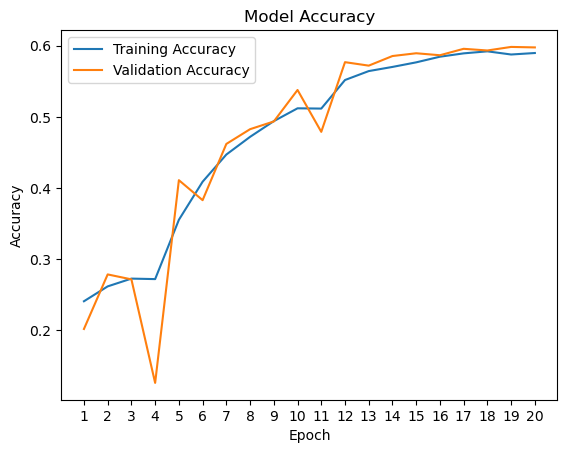

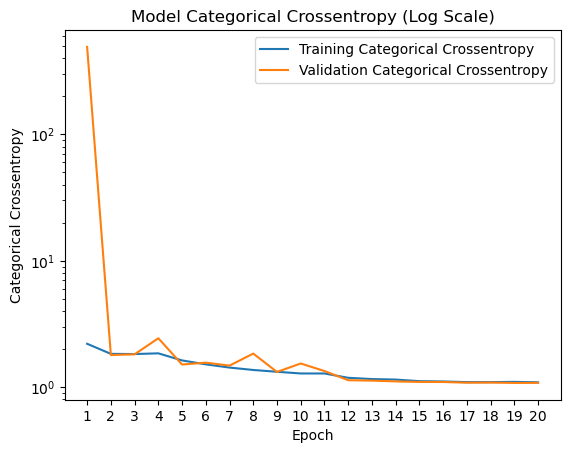

In [107]:
history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xticks(ticks=np.arange(EPOCHS), labels=np.arange(EPOCHS)+1)
plt.savefig(f'plots/{model_name}_accuracy.png')
plt.show()

history_df[['categorical_crossentropy', 'val_categorical_crossentropy']].plot()
plt.yscale('log')
plt.title('Model Categorical Crossentropy (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy')
plt.legend(['Training Categorical Crossentropy', 'Validation Categorical Crossentropy'])
plt.xticks(ticks=np.arange(EPOCHS), labels=np.arange(EPOCHS)+1)
plt.savefig(f'plots/{model_name}_cross_entropy.png')

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5326 - categorical_crossentropy: 1.2068 - loss: 1.2068
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
F1 Score: 0.5884864110036991
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       958
           1       0.47      0.06      0.11       111
           2       0.39      0.27      0.32      1024
           3       0.82      0.84      0.83      1774
           4       0.54      0.65      0.59      1233
           5       0.47      0.49      0.48      1247
           6       0.74      0.73      0.74       831

    accuracy                           0.60      7178
   macro avg       0.56      0.51      0.51      7178
weighted avg       0.59      0.60      0.59      7178



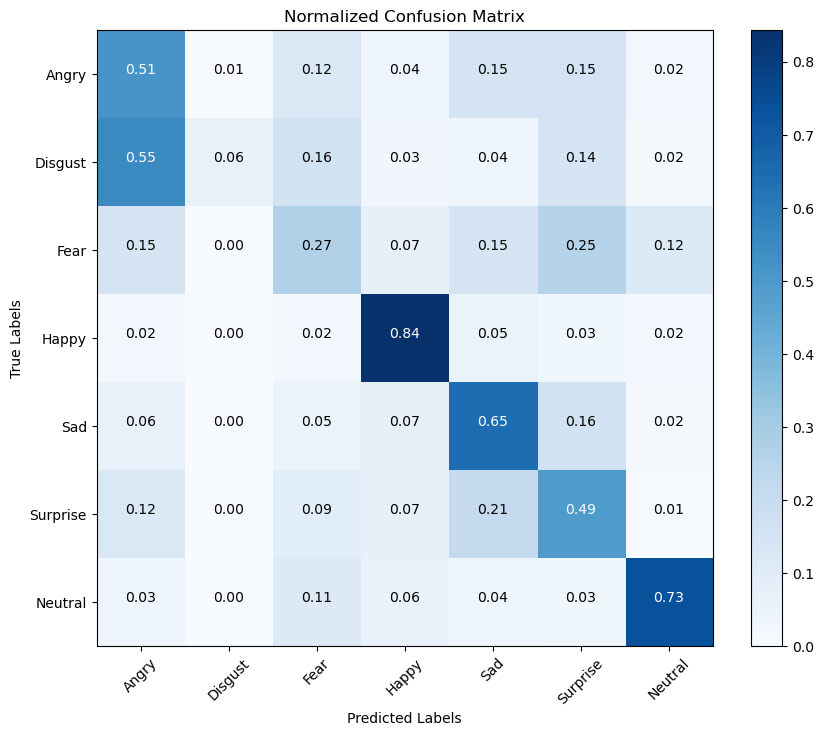

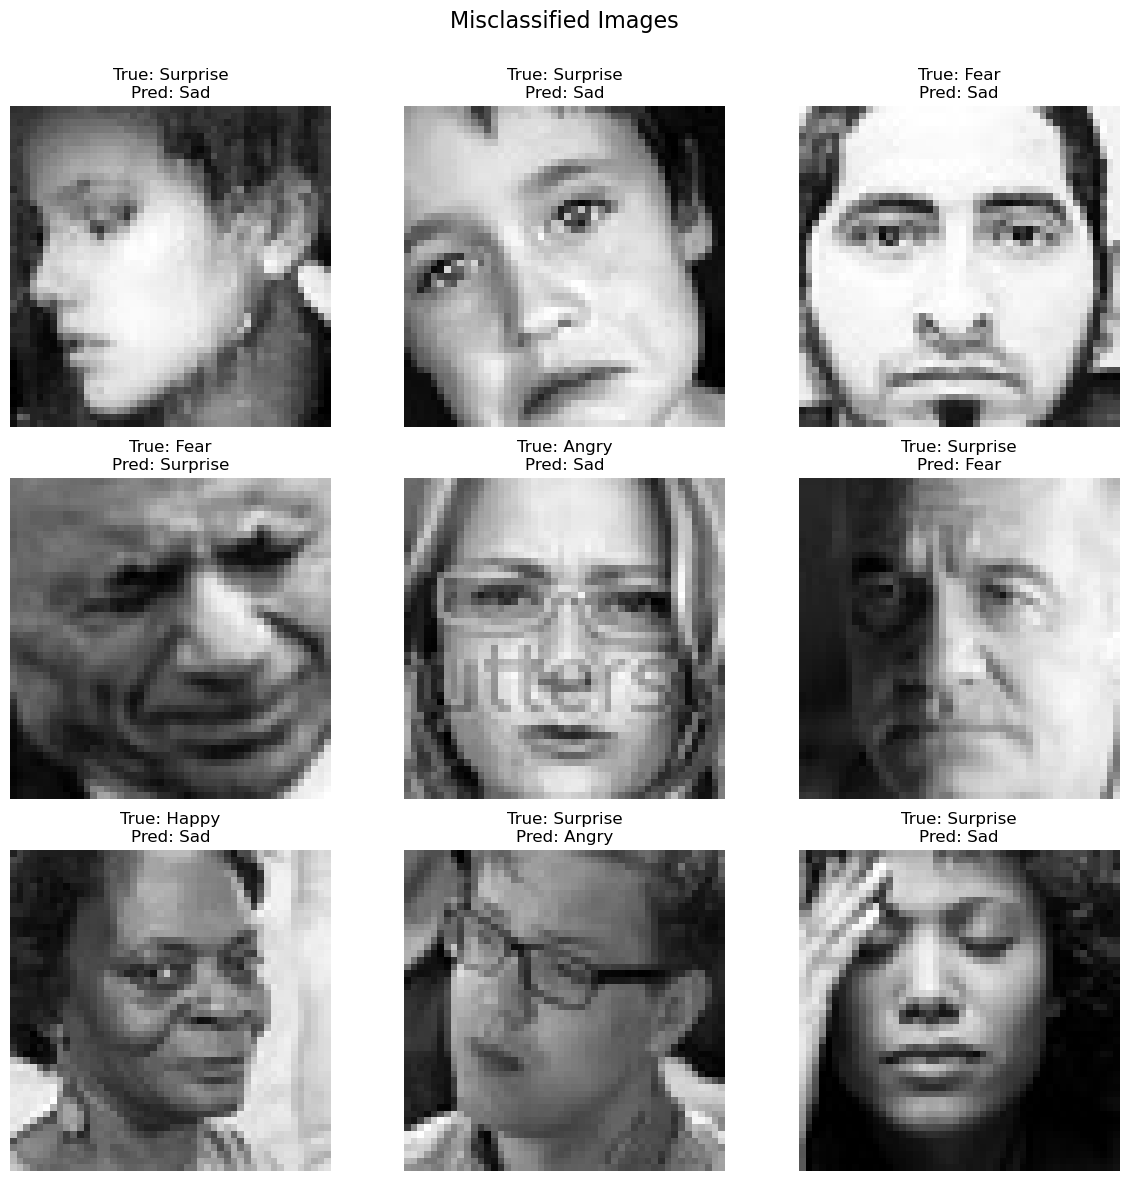

In [111]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_categorical_crossentropy = model.evaluate(test_dataset)

# Predict the labels for the test dataset
test_predictions = model.predict(test_dataset)
test_predictions = np.argmax(test_predictions, axis=1)

# Calculate the F1 score
f1 = f1_score(test_labels, test_predictions, average='weighted')
print(f"F1 Score: {f1}")
print(classification_report(test_labels, test_predictions))

# Create a confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Normalize the confusion matrix by row (i.e., by the number of samples in each true class)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, [class_names[i] for i in tick_marks], rotation=45)
plt.yticks(tick_marks, [class_names[i] for i in tick_marks])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add text annotations
thresh = conf_matrix_normalized.max() / 2.
for i, j in np.ndindex(conf_matrix_normalized.shape):
    plt.text(j, i, format(conf_matrix_normalized[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if conf_matrix_normalized[i, j] > thresh else "black")

plt.savefig(f'plots/{model_name}_confusion.png')
plt.show()

# Randomly sample 9 misclassified images
num_samples = 9
misclassified_indices = np.where(test_labels != test_predictions)[0]
np.random.seed(seed+5)
random_indices = np.random.choice(misclassified_indices, num_samples, replace=False)

# Plot the misclassified images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Misclassified Images', fontsize=16)

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]
    ax.imshow(test_images[idx].squeeze(), cmap='gray')
    true_label = class_names[test_labels[idx]]
    predicted_label = class_names[test_predictions[idx]]
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'plots/{model_name}_misclassified.png')
plt.show()